## Import all libs

In [2]:
import pandas as pd
import os
import openpyxl
import matplotlib
import numpy as np
import random
import re

### Open .xlsx files

In [3]:
file_path_1 = "../files/dataset_30k.xlsx"
def load_dataset(file_path):
    return pd.read_excel(file_path)

dataset = load_dataset(file_path_1)

# print(load_dataset(file_path_1))

In [4]:
def remove_n_percent_by_blocks(dataset, loss_percent, blocks=[(2, 2),(3, 2),(3, 1), (1, 3), (2, 1), (1, 1)]):
    data = dataset.copy()
    n_rows, n_cols = data.shape
    total_elements = n_rows * n_cols
    elements_to_remove = int(total_elements * loss_percent / 100)
    removed = 0
    while removed < elements_to_remove:
        block = blocks[np.random.randint(len(blocks))]
        h, w = block
        i = np.random.randint(0, n_rows - h + 1)
        j = np.random.randint(0, n_cols - w + 1)
        block_data = data.iloc[i:i+h, j:j+w].isna()
        new_missing = block_data.sum().sum()
        data.iloc[i:i+h, j:j+w] = np.nan
        removed += (h * w) - new_missing
        
    return data

def count_loss_percent(dataset):
    total_elements = dataset.size
    missing_elements = dataset.isna().sum().sum()
    return (missing_elements / total_elements) * 100

def save_current_state(data: pd.DataFrame, file_path: str):
    if os.path.exists(file_path):
        os.remove(file_path)

    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        data.to_excel(writer, index=False)
        worksheet = writer.sheets['Sheet1']
        for column in worksheet.columns:
            max_length = 0
            column_letter = column[0].column_letter

            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except Exception:
                    pass

            adjusted_width = (max_length + 2) * 1.1
            worksheet.column_dimensions[column_letter].width = adjusted_width

dataset_loss_5 = remove_n_percent_by_blocks(dataset, 5)
loss_percent_5 = count_loss_percent(dataset_loss_5)
save_current_state(dataset_loss_5, "dataset_loss_5.xlsx")
print(f"Loss percent: {loss_percent_5}%")

Loss percent: 5.0008333333333335%


### Mean Inputation methods

In [5]:
def delete_columns(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    return data.drop(columns=columns, axis=1)

def passport_partial_mask_calculation(df, passport_columns=None, mask_pattern='last_4'):
    result_df = df.copy()
    
    def extract_numeric_part(passport_number, pattern):
        if pd.isna(passport_number):
            return np.nan
        
        cleaned = re.sub(r'[^\d]', '', str(passport_number))
        
        if len(cleaned) != 10 or not cleaned.isdigit():
            return np.nan
        
        if pattern == 'last_4':
            return int(cleaned[6:])
        elif pattern == 'first_6':
            return int(cleaned[:6])
        elif pattern == 'series_only':
            return int(cleaned[:4])
        elif pattern == 'number_only':
            return int(cleaned[4:])
        else:
            raise ValueError("Неизвестный паттерн маскирования")
    
    def fill_with_masked_mean(df, column, pattern):
        numeric_values = df[column].apply(lambda x: extract_numeric_part(x, pattern))
        
        valid_values = numeric_values.dropna()
        
        if len(valid_values) == 0:
            print(f"В столбце '{column}' нет валидных паспортных данных")
            return df
        
        mean_value = valid_values.mean()
        print(f"Среднее значение замаскированных данных в '{column}': {mean_value:.2f}")
        
        missing_mask = df[column].isnull()
        missing_count = missing_mask.sum()
        
        if missing_count > 0:
            existing_passports = set(df[column].dropna())
            
            for idx in df[missing_mask].index:
                new_passport = generate_passport_from_masked_mean(mean_value, pattern, existing_passports)
                df.at[idx, column] = new_passport
                existing_passports.add(new_passport)
            
            print(f"Заполнено {missing_count} пропусков в столбце '{column}'")
        
        return df
    
    def generate_passport_from_masked_mean(mean_value, pattern, existing_passports):
        while True:
            if pattern == 'last_4':
                base_number = int(mean_value) % 10000
                last_4 = f"{base_number:04d}"
                first_6 = f"{random.randint(1, 99):02d}{random.randint(0, 99):02d}{random.randint(0, 99):02d}"
                passport = first_6 + last_4
                
            elif pattern == 'first_6':
                base_number = max(10101, min(999999, int(mean_value)))
                first_6 = f"{base_number:06d}"
                last_4 = f"{random.randint(0, 9999):04d}"
                passport = first_6 + last_4
                
            elif pattern == 'series_only':
                series = max(101, min(9999, int(mean_value)))
                series_str = f"{series:04d}"
                number = f"{random.randint(1, 999999):06d}"
                passport = series_str + number
                
            elif pattern == 'number_only':
                number = max(1, min(999999, int(mean_value)))
                number_str = f"{number:06d}"
                series = f"{random.randint(1, 99):02d}{random.randint(0, 99):02d}"
                passport = series + number_str
            
            formatted = f"{passport[:2]} {passport[2:4]} {passport[4:]}"
            if formatted not in existing_passports:
                return formatted
    
    if passport_columns is None:
        passport_columns = []
        for column in result_df.columns:
            sample_data = result_df[column].dropna().head(5)
            if len(sample_data) > 0:
                if any(re.match(r'\d{2} \d{2} \d{6}', str(x)) for x in sample_data):
                    passport_columns.append(column)
    
    print(f"Обрабатываемые паспортные столбцы: {passport_columns}")
    print(f"Паттерн маскирования: {mask_pattern}")
    
    for column in passport_columns:
        if column in result_df.columns:
            result_df = fill_with_masked_mean(result_df, column, mask_pattern)
    
    return result_df

def generalize_snils(df: pd.DataFrame, snils_column: str) -> pd.DataFrame:
    if snils_column not in df.columns:
        raise KeyError(f"Column '{snils_column}' not found in dataset")

    result = df.copy()

    result[snils_column] = result[snils_column].apply(
        lambda x: 'Гражданин РФ' if x not in ['Гражданин РБ', 'Гражданин РК'] else x
    )

    col_series = result[snils_column].fillna('').astype(str)
    kz_rows = int(col_series.str.contains('Гражданин РК', na=False).sum())
    by_rows = int(col_series.str.contains('Гражданин РБ', na=False).sum())
    ru_rows = int(col_series.str.contains('Гражданин РФ', na=False).sum())

    counts = {
        'Гражданин РФ': ru_rows,
        'Гражданин РБ': by_rows,
        'Гражданин РК': kz_rows,
    }
    most_popular = max(counts, key=counts.get)

    result[snils_column] = result[snils_column].replace("", np.nan)
    result[snils_column] = result[snils_column].fillna(most_popular)

    return result

def fill_card_with_mean(df: pd.DataFrame, card_column: str) -> pd.DataFrame:
    result = df.copy()
    col = result[card_column].astype(str)

    numeric = col.replace("nan", np.nan).apply(
        lambda x: re.sub(r"[^\d]", "", str(x)) if pd.notna(x) else x
    )

    lengths = numeric.dropna().map(len)
    if lengths.empty:
        print(f"В столбце '{card_column}' нет валидных номеров карт")
        return result

    target_len = int(lengths.mode().iloc[0])

    valid = numeric[numeric.map(lambda x: len(str(x)) == target_len if pd.notna(x) else False)]
    if valid.empty:
        print(f"В столбце '{card_column}' нет номеров длиной {target_len}")
        return result

    mean_value = int(valid.astype(int).mean().round())
    print(f"Среднее значение по картам в '{card_column}': {mean_value}")

    def mask_pattern(s: str) -> str:
        return re.sub(r"\d", "X", s)

    non_null_raw = result[card_column].dropna().astype(str)
    if non_null_raw.empty:
        pattern = "XXXXXXXXXXXXXXXX"
    else:
        patterns = non_null_raw.apply(mask_pattern)
        pattern = patterns.mode().iloc[0]

    def format_with_pattern(number: int, pattern: str) -> str:
        digits = list(str(number))
        if len(digits) > target_len:
            digits = digits[-target_len:]
        elif len(digits) < target_len:
            digits = list("0" * (target_len - len(digits)) + "".join(digits))

        result_chars = []
        digit_idx = 0
        for ch in pattern:
            if ch.isdigit() or ch == "X":
                if digit_idx < len(digits):
                    result_chars.append(digits[digit_idx])
                    digit_idx += 1
                else:
                    result_chars.append("0")
            else:
                result_chars.append(ch)
        return "".join(result_chars)

    fill_value = format_with_pattern(mean_value, pattern)

    mask = result[card_column].isna()
    result.loc[mask, card_column] = fill_value

    return result

def fill_date_with_mean(df: pd.DataFrame, column: str, fmt: str = "%Y-%m-%dT%H:%M%z") -> pd.DataFrame:
    result = df.copy()
    result[column] = result[column].replace("", np.nan)

    dt = pd.to_datetime(result[column], errors="coerce", format=fmt)

    valid = dt.dropna()
    if len(valid) == 0:
        print(f"В столбце '{column}' нет валидных дат")
        return result

    mean_ts = valid.view("int64").mean()
    mean_dt = pd.to_datetime(int(mean_ts))

    print(f"Средняя дата для '{column}': {mean_dt}")

    if mean_dt.tz is not None:
        mean_dt = mean_dt.tz_localize(None)
    
    formatted_date = mean_dt.strftime("%Y-%m-%dT%H:%M+03:00")

    mask = result[column].isna()
    result.loc[mask, column] = formatted_date

    return result

def fill_with_mean(dataset, columns):
    return dataset.fillna(dataset[columns].mean().round(-2))

def impute_text_list_with_mean_item(
    df: pd.DataFrame,
    column: str,
    sep: str = ",",
    k: int = 3,
) -> pd.DataFrame:
    result = df.copy()
    result[column] = result[column].replace("", np.nan)

    all_items = (
        result[column]
        .dropna()
        .astype(str)
        .str.split(sep)
        .explode()
        .str.strip()
    )
    all_items = all_items[all_items != ""]
    unique_items = all_items.unique()

    if len(unique_items) == 0:
        print(f"Столбец '{column}': нет данных для импутации")
        return result

    unique_items_sorted = sorted(unique_items)
    item2id = {item: i + 1 for i, item in enumerate(unique_items_sorted)}
    id2item = {v: k for k, v in item2id.items()}
    print(f"Столбец '{column}': {len(item2id)} уникальных элементов")

    def row_mean_id(text):
        if pd.isna(text):
            return np.nan
        parts = [p.strip() for p in str(text).split(sep)]
        ids = [item2id[p] for p in parts if p in item2id]
        if not ids:
            return np.nan
        return float(np.mean(ids))

    mean_ids = result[column].apply(row_mean_id)

    col_mean = mean_ids.mean(skipna=True)
    if np.isnan(col_mean):
        print(f"Столбец '{column}': не удалось вычислить среднее id")
        return result

    all_ids = np.arange(1, len(id2item) + 1)
    distances = np.abs(all_ids - col_mean)
    nearest_indices = np.argsort(np.stack([distances, all_ids], axis=1), axis=0)[:, 0][:k]
    chosen_ids = sorted(all_ids[nearest_indices])
    replacement_items = [id2item[i] for i in chosen_ids]

    replacement_str = f"{sep} ".join(replacement_items)

    print(f"Столбец '{column}': среднее id={col_mean:.3f}, выбраны id {chosen_ids}")

    mask = result[column].isna()
    result.loc[mask, column] = replacement_str

    return result


def restore_dataset_mean_impute(dataset):
    restored_dataset = dataset.copy()
    restored_dataset = fill_with_mean(restored_dataset, ["Стоимость анализов"])
    restored_dataset = generalize_snils(restored_dataset, "СНИЛС")
    restored_dataset = fill_card_with_mean(restored_dataset, "Карта оплаты")
    restored_dataset = fill_date_with_mean(restored_dataset, "Дата готовности анализов")
    restored_dataset = fill_date_with_mean(restored_dataset, "Дата посещения врача")
    restored_dataset = impute_text_list_with_mean_item(restored_dataset, "Симптомы")
    restored_dataset = impute_text_list_with_mean_item(restored_dataset, "Анализы", k=2)
    restored_dataset = impute_text_list_with_mean_item(restored_dataset, "Врач", k=1)

    restored_dataset = impute_text_list_with_mean_item(restored_dataset, "Фамилия", k=1)
    restored_dataset = impute_text_list_with_mean_item(restored_dataset, "Имя", k=1)
    restored_dataset = impute_text_list_with_mean_item(restored_dataset, "Отчество", k=1)
    restored_dataset["Паспортные данные"] = restored_dataset["Паспортные данные"].replace("", np.nan)
    restored_dataset = passport_partial_mask_calculation(
        restored_dataset,
        ["Паспортные данные"],
        "series_only"
    )
    return restored_dataset

restored_with_mean_dataset = restore_dataset_mean_impute(dataset_loss_5)
save_current_state(restored_with_mean_dataset, "dataset_loss_5_recovered_with_mean.xlsx")

Среднее значение по картам в 'Карта оплаты': 4134016824669100


C:\Users\andre\AppData\Local\Temp\ipykernel_17800\3651725267.py:199: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  mean_ts = valid.view("int64").mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_17800\3651725267.py:199: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  mean_ts = valid.view("int64").mean()


Средняя дата для 'Дата готовности анализов': 2020-07-04 04:51:04.818355712
Средняя дата для 'Дата посещения врача': 2020-07-02 11:11:05.534493696
Столбец 'Симптомы': 194 уникальных элементов
Столбец 'Симптомы': среднее id=98.485, выбраны id [np.int64(97), np.int64(98), np.int64(99)]
Столбец 'Анализы': 101 уникальных элементов
Столбец 'Анализы': среднее id=50.582, выбраны id [np.int64(50), np.int64(51)]
Столбец 'Врач': 21 уникальных элементов
Столбец 'Врач': среднее id=10.029, выбраны id [np.int64(10)]
Столбец 'Фамилия': 631 уникальных элементов
Столбец 'Фамилия': среднее id=317.117, выбраны id [np.int64(317)]
Столбец 'Имя': 382 уникальных элементов
Столбец 'Имя': среднее id=192.242, выбраны id [np.int64(192)]
Столбец 'Отчество': 378 уникальных элементов
Столбец 'Отчество': среднее id=190.395, выбраны id [np.int64(190)]
Обрабатываемые паспортные столбцы: ['Паспортные данные']
Паттерн маскирования: series_only
Среднее значение замаскированных данных в 'Паспортные данные': 5491.68
Заполне

### Linear Regression imputation

In [6]:
from sklearn.linear_model import LinearRegression


def build_column_encoder(col: pd.Series) -> dict:
    """
    Строит простой энкодер для столбца: 
    - числовые оставляем как есть,
    - категориальные/строки -> словарь value -> id (1..N).
    """
    if pd.api.types.is_numeric_dtype(col):
        return {"type": "numeric"}
    # категориальный/текстовый
    values = col.dropna().astype(str).unique()
    mapping = {v: i + 1 for i, v in enumerate(sorted(values))}
    return {"type": "categorical", "mapping": mapping}

def encode_column(col: pd.Series, enc: dict) -> pd.Series:
    if enc["type"] == "numeric":
        return pd.to_numeric(col, errors="coerce")
    mapping = enc["mapping"]
    return col.astype(str).map(mapping).astype(float)

def decode_column(encoded: pd.Series, enc: dict, orig_dtype) -> pd.Series:
    if enc["type"] == "numeric":
        return encoded.astype(orig_dtype)
    mapping = enc["mapping"]
    inv_mapping = {v: k for k, v in mapping.items()}
    # для пропусков/непопавших значений оставляем NaN
    def _decode(v):
        if pd.isna(v):
            return np.nan
        # берём ближайший id
        v_int = int(round(float(v)))
        return inv_mapping.get(v_int, np.nan)
    decoded = encoded.map(_decode)
    return decoded.astype(orig_dtype)

def impute_column_by_regression(
    df: pd.DataFrame,
    target_col: str,
    encoders: dict,
    restored_mask: pd.DataFrame | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None]:
    """
    Восстанавливает пропуски в ОДНОМ столбце target_col с помощью линейной регрессии,
    используя только damaged_df. Разрешает пропуски в признаках: они заменяются на 0.
    Если передан restored_mask, в нём помечаются восстановленные ячейки.
    """
    result = df.copy()

    if target_col not in result.columns:
        raise KeyError(f"Колонка '{target_col}' не найдена")

    target_enc = encoders[target_col]
    target_encoded = encode_column(result[target_col], target_enc)

    feature_cols = [c for c in result.columns if c != target_col]

    X_encoded = pd.DataFrame(index=result.index)
    for col in feature_cols:
        X_encoded[col] = encode_column(result[col], encoders[col])

    mask_known = target_encoded.notna()
    mask_unknown = ~mask_known

    if mask_known.sum() == 0 or mask_unknown.sum() == 0:
        print(f"'{target_col}': недостаточно данных для обучения/предсказания")
        return result, restored_mask

    X_train = X_encoded.loc[mask_known, :]
    y_train = target_encoded.loc[mask_known]

    X_pred = X_encoded.loc[mask_unknown, :]

    X_train = X_train.fillna(0)
    X_pred = X_pred.fillna(0)

    if len(X_train) == 0 or len(X_pred) == 0:
        print(f"'{target_col}': нет валидных строк после подготовки данных")
        return result, restored_mask

    model = LinearRegression()
    model.fit(X_train.values, y_train.values)

    y_pred = model.predict(X_pred.values)

    # вставляем предсказания
    target_encoded.loc[mask_unknown] = y_pred

    restored_col = decode_column(target_encoded, target_enc, result[target_col].dtype)
    result[target_col] = restored_col

    # помечаем восстановленные ячейки
    if restored_mask is not None:
        restored_mask.loc[mask_unknown, target_col] = True

    print(
        f"'{target_col}': линейная регрессия восстановила "
        f"{int(mask_unknown.sum())} пропусков"
    )

    return result, restored_mask

def restore_dataset_full_regression(damaged_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Восстанавливает ВСЕ столбцы damaged_df с помощью линейной регрессии,
    НЕ используя исходный (неповреждённый) датасет.
    Возвращает:
      - restored: восстановленный датасет
      - restored_mask: DataFrame того же размера с True в восстановленных ячейках
    """
    restored = damaged_df.copy()

    # маска восстановленных ячеек
    restored_mask = pd.DataFrame(False, index=restored.index, columns=restored.columns)

    encoders = {}
    for col in restored.columns:
        encoders[col] = build_column_encoder(restored[col])

    for col in restored.columns:
        if restored[col].isna().sum() == 0:
            continue
        restored, restored_mask = impute_column_by_regression(restored, col, encoders, restored_mask)

    return restored, restored_mask

def show_linear_regression_weights(df: pd.DataFrame, target_col: str):
    """
    Обучает линейную регрессию для target_col на текущем df
    и печатает коэффициенты w_n по признакам.
    """
    if target_col not in df.columns:
        raise KeyError(f"Колонка '{target_col}' не найдена")

    # строим энкодеры
    encoders = {col: build_column_encoder(df[col]) for col in df.columns}

    target_enc = encoders[target_col]
    y = encode_column(df[target_col], target_enc)

    feature_cols = [c for c in df.columns if c != target_col]
    X = pd.DataFrame(index=df.index)
    for col in feature_cols:
        X[col] = encode_column(df[col], encoders[col])

    mask = y.notna()
    X_train = X.loc[mask, :].fillna(0)
    y_train = y.loc[mask]

    model = LinearRegression()
    model.fit(X_train.values, y_train.values)

    print(f"Целевая колонка: {target_col}")
    print(f"Свободный член w0: {model.intercept_}")

    # print("Коэффициенты w_n по признакам:")
    # for fname, w in zip(feature_cols, model.coef_):
    #     print(f"  {fname:30s} -> {w}")

    print("Коэффициенты w_n по признакам:")
    coef_items = list(zip(feature_cols, model.coef_))
    # сортировка по модулю веса по убыванию:
    coef_items_sorted = sorted(coef_items, key=lambda x: abs(x[1]), reverse=True)
    for fname, w in coef_items_sorted:
        print(f"  {fname:30s} -> {w}")
    return coef_items

restored_with_linear_regression, restored_lr_mask = restore_dataset_full_regression(dataset_loss_5)
# save_current_state(restored_with_linear_regression, "dataset_loss_5_recovered_with_linear_regression.xlsx")
# save_current_state(restored_lr_mask.astype(int), "dataset_loss_5_recovered_with_linear_regression_mask.xlsx")

print(show_linear_regression_weights(restored_with_linear_regression, "Стоимость анализов"))

'Фамилия': линейная регрессия восстановила 972 пропусков
'Имя': линейная регрессия восстановила 1426 пропусков
'Отчество': линейная регрессия восстановила 1670 пропусков
'Паспортные данные': линейная регрессия восстановила 1592 пропусков
'СНИЛС': линейная регрессия восстановила 1551 пропусков
'Симптомы': линейная регрессия восстановила 1590 пропусков
'Врач': линейная регрессия восстановила 1521 пропусков
'Дата посещения врача': линейная регрессия восстановила 1618 пропусков
'Анализы': линейная регрессия восстановила 1640 пропусков
'Дата готовности анализов': линейная регрессия восстановила 1758 пропусков
'Стоимость анализов': линейная регрессия восстановила 1644 пропусков
'Карта оплаты': линейная регрессия восстановила 1021 пропусков
Целевая колонка: Стоимость анализов
Свободный член w0: 5592.686063429317
Коэффициенты w_n по признакам:
  Врач                           -> -123.4539234446753
  Дата готовности анализов       -> 2.2190259065609657
  Дата посещения врача           -> -1.581

### Calсucate prediction accuracy

In [7]:
def calculate_eucluidian_dist(df1: pd.DataFrame, df2: pd.DataFrame) -> float:
    """
    Считает суммарное квадрат Евклидово расстояние между df1 и df2
    по числовым столбцам. Чем МЕНЬШЕ значение, тем ближе восстановленный
    датасет к исходному.
    """
    # приведение к одинаковому порядку столбцов и индексов
    df2 = df2.reindex(index=df1.index, columns=df1.columns)

    # берём только числовые столбцы (для строк будет отдельная метрика, если нужно)
    num1 = df1.select_dtypes(include=[np.number])
    num2 = df2[num1.columns]

    # заменим NaN нулями, чтобы не ломать расчёт
    num1 = num1.fillna(0)
    num2 = num2.fillna(0)

    diff = num1.values - num2.values
    sq_dist = np.sum(diff ** 2)

    return float(sq_dist)

def calculate_chebyshev_dist(df1: pd.DataFrame, df2: pd.DataFrame) -> float:
    """
    Считает расстояние Чебышева между df1 и df2
    по числовым столбцам: max |x_i - y_i|.
    Чем МЕНЬШЕ значение, тем ближе восстановленный датасет к исходному.
    """
    df2 = df2.reindex(index=df1.index, columns=df1.columns)

    num1 = df1.select_dtypes(include=[np.number])
    num2 = df2[num1.columns]

    num1 = num1.fillna(0)
    num2 = num2.fillna(0)

    diff = np.abs(num1.values - num2.values)
    cheb_dist = np.max(diff)

    return float(cheb_dist)

# Евклидово расстояние
dist_mean_eucl = calculate_eucluidian_dist(dataset, restored_with_mean_dataset)
dist_lr_eucl   = calculate_eucluidian_dist(dataset, restored_with_linear_regression)

print(f"Euclidean^2 distance (mean):        {dist_mean_eucl}")
print(f"Euclidean^2 distance (lin. reg.):  {dist_lr_eucl}")
print("Ratio (mean / lin.reg):", dist_mean_eucl / dist_lr_eucl)

# Расстояние Чебышева
dist_mean_cheb = calculate_chebyshev_dist(dataset, restored_with_mean_dataset)
dist_lr_cheb   = calculate_chebyshev_dist(dataset, restored_with_linear_regression)

print(f"Chebyshev distance (mean):         {dist_mean_cheb}")
print(f"Chebyshev distance (lin. reg.):   {dist_lr_cheb}")
print("Ratio Chebyshev (mean / lin.reg):", dist_mean_cheb / dist_lr_cheb)

Euclidean^2 distance (mean):        37203860000.0
Euclidean^2 distance (lin. reg.):  36724991551.92238
Ratio (mean / lin.reg): 1.0130393072357986
Chebyshev distance (mean):         28400.0
Chebyshev distance (lin. reg.):   27994.001491896764
Ratio Chebyshev (mean / lin.reg): 1.014503053742451


### Clusterisation and Visualisation

Del: удаляем признак 'Отчество', Ph = 2.8483
Del: удаляем признак 'Паспортные данные', Ph = 2.4626
Del: удаляем признак 'Симптомы', Ph = 2.1094
Del: удаляем признак 'Анализы', Ph = 1.7822
Del: удаляем признак 'Фамилия', Ph = 1.4246
Del: удаляем признак 'Карта оплаты', Ph = 1.0651
Del: удаляем признак 'Имя', Ph = 0.7213
Del: удаляем признак 'Врач', Ph = 0.4075
Del: удаляем признак 'Стоимость анализов', Ph = 0.1845
Итоговый набор признаков: ['СНИЛС', 'Дата посещения врача', 'Дата готовности анализов']
Ph (original): 0.18446943648600758


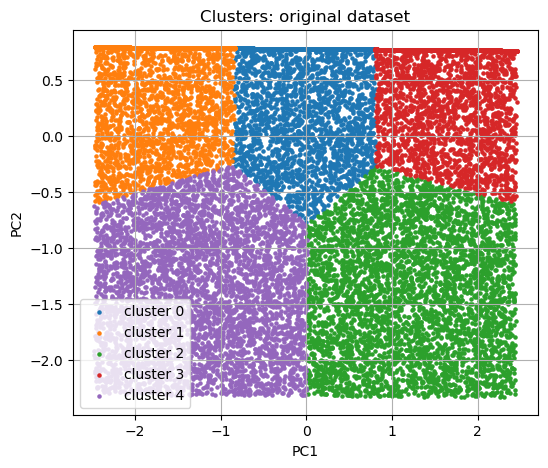

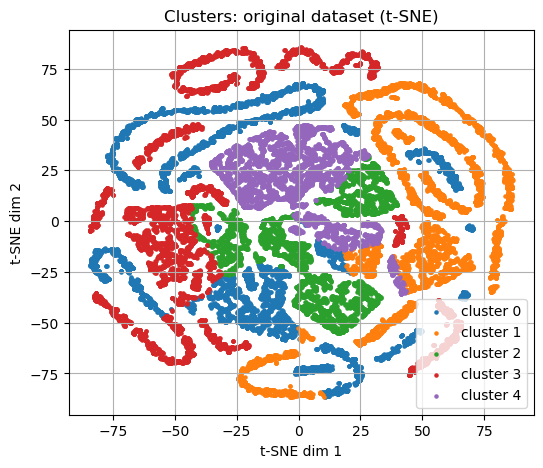

Del: удаляем признак 'Фамилия', Ph = 2.9573
Del: удаляем признак 'Паспортные данные', Ph = 2.6168
Del: удаляем признак 'Имя', Ph = 2.2416
Del: удаляем признак 'Отчество', Ph = 1.8924
Del: удаляем признак 'Анализы', Ph = 1.5212
Del: удаляем признак 'Симптомы', Ph = 1.1649
Del: удаляем признак 'Карта оплаты', Ph = 0.7923
Del: удаляем признак 'Врач', Ph = 0.4603
Del: удаляем признак 'Стоимость анализов', Ph = 0.2589
Итоговый набор признаков: ['СНИЛС', 'Дата посещения врача', 'Дата готовности анализов']
Ph (mean impute): 0.2588852176302844


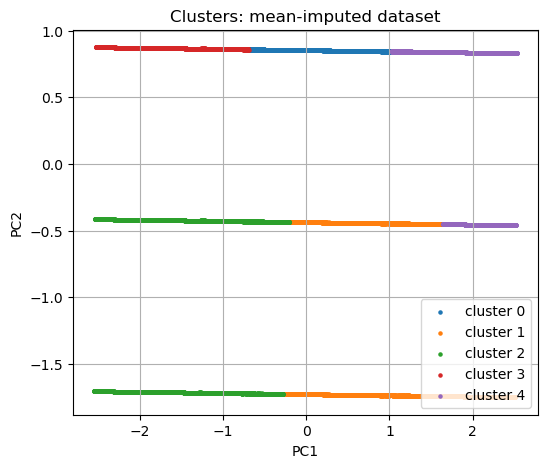

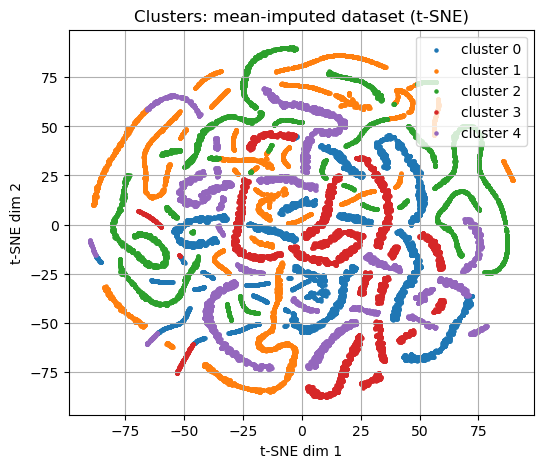

Del: удаляем признак 'Имя', Ph = 2.8142
Del: удаляем признак 'Отчество', Ph = 2.4692
Del: удаляем признак 'Симптомы', Ph = 2.1243
Del: удаляем признак 'Паспортные данные', Ph = 1.7641
Del: удаляем признак 'Фамилия', Ph = 1.4263
Del: удаляем признак 'Анализы', Ph = 1.0735
Del: удаляем признак 'Карта оплаты', Ph = 0.7284
Del: удаляем признак 'Врач', Ph = 0.4142
Del: удаляем признак 'Стоимость анализов', Ph = 0.1904
Итоговый набор признаков: ['СНИЛС', 'Дата посещения врача', 'Дата готовности анализов']
Ph (linear regression): 0.1903671435702985


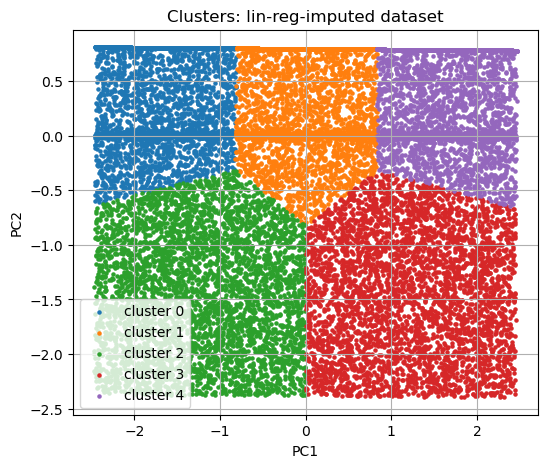

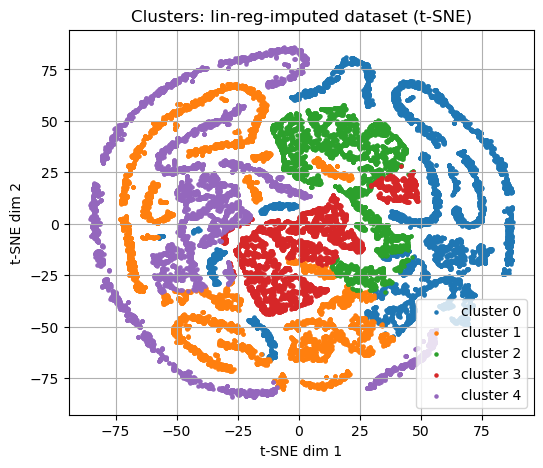

TypeError: loop of ufunc does not support argument 0 of type int which has no callable sqrt method

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def prepare_numeric_matrix(df: pd.DataFrame):
    """Кодирует все столбцы (как в регрессии) и нормирует."""
    # строим энкодеры по всему df
    encoders = {col: build_column_encoder(df[col]) for col in df.columns}
    X = pd.DataFrame(index=df.index)
    for col in df.columns:
        X[col] = encode_column(df[col], encoders[col])
    # заменяем NaN нулями
    X = X.fillna(0.0)
    # выкидываем константные признаки
    var = X.var(axis=0)
    non_const_cols = var[var > 0].index
    X = X[non_const_cols]
    # нормировка
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    return X, X_scaled, encoders, scaler, non_const_cols

def ph_index(X: np.ndarray, labels: np.ndarray) -> float:
    """Простейшая реализация индекса Ph по формуле вида S_within / S_between."""
    # X: (n_samples, n_features)
    # labels: (n_samples,)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    if n_clusters < 2:
        return np.inf

    # глобальный центр
    mu = X.mean(axis=0)

    # внутрикластерная сумма квадратов
    S_within = 0.0
    # межкластерная сумма квадратов
    S_between = 0.0

    for c in unique_labels:
        mask = labels == c
        Xc = X[mask]
        if len(Xc) == 0:
            continue
        mu_c = Xc.mean(axis=0)
        S_within += np.sum((Xc - mu_c) ** 2)
        S_between += len(Xc) * np.sum((mu_c - mu) ** 2)

    if S_between == 0:
        return np.inf
    return float(S_within / S_between)

def simple_isodata_like(X: np.ndarray, K_start: int = 5, max_iter: int = 10) -> np.ndarray:
    """
    Упрощённый ISODATA-подобный алгоритм на базе KMeans.
    На практике: просто KMeans с фиксированным числом кластеров.
    При необходимости сюда можно добавить операции split/merge.
    """
    km = KMeans(n_clusters=K_start, n_init=10, max_iter=max_iter, random_state=42)
    labels = km.fit_predict(X)
    return labels

def del_feature_selection(X: pd.DataFrame, K_start: int = 5, min_features: int = 3) -> list[str]:
    """
    Метод последовательного сокращения (Del).
    На вход: числовой DataFrame X (после кодирования, но до нормировки).
    Возвращает список имён выбранных признаков.
    """
    current_features = list(X.columns)
    # нормировка (по текущим признакам) каждый раз будет пересчитываться
    while len(current_features) > min_features:
        # базовое качество на всех текущих признаках
        scaler = StandardScaler()
        X_base = scaler.fit_transform(X[current_features].values)
        labels_base = simple_isodata_like(X_base, K_start=K_start)
        ph_base = ph_index(X_base, labels_base)

        # ищем признак, удаление которого МЕНЬШЕ всего ухудшает Ph
        best_feature_to_drop = None
        best_ph = None  # хотим минимальный Ph
        for feat in current_features:
            feats_subset = [f for f in current_features if f != feat]
            X_sub = scaler.fit_transform(X[feats_subset].values)
            labels_sub = simple_isodata_like(X_sub, K_start=K_start)
            ph_sub = ph_index(X_sub, labels_sub)

            if best_ph is None or ph_sub < best_ph:
                best_ph = ph_sub
                best_feature_to_drop = feat

        # если удаление ухудшает качество (Ph сильно растёт) — можно остановиться
        if best_ph is None or best_ph > ph_base:
            break

        # удаляем наименее информативный признак
        current_features.remove(best_feature_to_drop)
        print(f"Del: удаляем признак '{best_feature_to_drop}', Ph = {best_ph:.4f}")

    print("Итоговый набор признаков:", current_features)
    return current_features

def median_cluster_centers(X: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """Вычисляет медианные центры кластеров (медианный вектор по каждому кластеру)."""
    unique_labels = np.unique(labels)
    centers = []
    for c in unique_labels:
        mask = labels == c
        Xc = X[mask]
        if len(Xc) == 0:
            continue
        centers.append(np.median(Xc, axis=0))
    return np.vstack(centers)

def plot_clusters_2d(X_scaled: np.ndarray, labels: np.ndarray, title: str):
    """
    Проецирует данные в 2D с помощью PCA и рисует scatter по кластерам.
    """
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X_scaled)

    plt.figure(figsize=(6, 5))
    for lab in np.unique(labels):
        mask = labels == lab
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=5, label=f"cluster {lab}")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

def phi_index(tp: int, tn: int, fp: int, fn: int) -> float:
    """
    Коэффициент Фи:
    Φ = (TP*TN - FN*FP) / sqrt((TP+FN)(TP+FP)(FN+TN)(FP+TN))
    """
    num = tp * tn - fn * fp
    denom = (tp + fn) * (tp + fp) * (fn + tn) * (fp + tn)
    if denom == 0:
        return 0.0
    denom = float(denom)  # приведение к float, чтобы sqrt корректно работал
    return float(num / np.sqrt(denom))

def phi_for_two_clusterings(labels_a: np.ndarray, labels_b: np.ndarray) -> float:
    """
    Строит TP, TN, FP, FN по всем парам объектов:
      - положительный класс: пара объектов в ОДНОМ кластере.
      - сравниваются два разбиения labels_a и labels_b.
    Возвращает коэффициент Фи между двумя кластеризациями.
    """
    n = len(labels_a)
    tp = tn = fp = fn = 0

    for i in range(n):
        for j in range(i + 1, n):
            same_a = labels_a[i] == labels_a[j]
            same_b = labels_b[i] == labels_b[j]

            if same_a and same_b:
                tp += 1
            elif same_a and not same_b:
                fn += 1
            elif not same_a and same_b:
                fp += 1
            else:
                tn += 1

    return phi_index(tp, tn, fp, fn)

def plot_clusters_tsne(X_scaled: np.ndarray, labels: np.ndarray, title: str):
    """
    Строит 2D-визуализацию кластеров с помощью t-SNE.
    X_scaled — нормированные признаки (как для PCA).
    """
    tsne = TSNE(
        n_components=2,
        perplexity=30,      # «эффективное» число ближайших соседей
        learning_rate=200,
        random_state=42,
        init="random",
        verbose=0,
        # max_iter=1000,    # если твоя версия sklearn поддерживает, можно раскомментировать
    )
    X_2d = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(6, 5))
    for lab in np.unique(labels):
        mask = labels == lab
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=5, label=f"cluster {lab}")
    plt.title(title + " (t-SNE)")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend()
    plt.grid(True)
    plt.show()


# =========================
# 1) Исходный датасет
# =========================
X_full, X_scaled_full, enc_full, scaler_full, non_const_full = prepare_numeric_matrix(dataset)
selected_full = del_feature_selection(X_full[non_const_full], K_start=5, min_features=3)

scaler_full_sel = StandardScaler()
X_full_sel = scaler_full_sel.fit_transform(X_full[selected_full].values)
labels_full = simple_isodata_like(X_full_sel, K_start=5)
ph_full = ph_index(X_full_sel, labels_full)
med_centers_full = median_cluster_centers(X_full_sel, labels_full)
print("Ph (original):", ph_full)

# Визуализация кластеров для исходного набора
plot_clusters_2d(X_full_sel, labels_full, "Clusters: original dataset")
plot_clusters_tsne(X_full_sel, labels_full, "Clusters: original dataset")

# =========================
# 2) Mean-impute датасет
# =========================
X_mean, X_scaled_mean, enc_mean, scaler_mean, non_const_mean = prepare_numeric_matrix(restored_with_mean_dataset)
selected_mean = del_feature_selection(X_mean[non_const_mean], K_start=5, min_features=3)

scaler_mean_sel = StandardScaler()
X_mean_sel = scaler_mean_sel.fit_transform(X_mean[selected_mean].values)
labels_mean = simple_isodata_like(X_mean_sel, K_start=5)
ph_mean = ph_index(X_mean_sel, labels_mean)
med_centers_mean = median_cluster_centers(X_mean_sel, labels_mean)
print("Ph (mean impute):", ph_mean)

# Визуализация кластеров для mean-impute
plot_clusters_2d(X_mean_sel, labels_mean, "Clusters: mean-imputed dataset")
plot_clusters_tsne(X_mean_sel, labels_mean, "Clusters: mean-imputed dataset")

# =========================
# 3) Linear regression датасет
# =========================
X_lr, X_scaled_lr, enc_lr, scaler_lr, non_const_lr = prepare_numeric_matrix(restored_with_linear_regression)
selected_lr = del_feature_selection(X_lr[non_const_lr], K_start=5, min_features=3)

scaler_lr_sel = StandardScaler()
X_lr_sel = scaler_lr_sel.fit_transform(X_lr[selected_lr].values)
labels_lr = simple_isodata_like(X_lr_sel, K_start=5)
ph_lr = ph_index(X_lr_sel, labels_lr)
med_centers_lr = median_cluster_centers(X_lr_sel, labels_lr)
print("Ph (linear regression):", ph_lr)

# Визуализация кластеров для lin.reg-impute
plot_clusters_2d(X_lr_sel, labels_lr, "Clusters: lin-reg-imputed dataset")
plot_clusters_tsne(X_lr_sel, labels_lr, "Clusters: lin-reg-imputed dataset")

# =========================
# 4) Сравнение кластеризаций через Φ-индекс
# =========================
phi_full_mean = phi_for_two_clusterings(labels_full, labels_mean)
phi_full_lr   = phi_for_two_clusterings(labels_full, labels_lr)
phi_mean_lr   = phi_for_two_clusterings(labels_mean, labels_lr)

print("\nPhi between clusterings:")
print(f"  Φ(original, mean-impute)       = {phi_full_mean:.4f}")
print(f"  Φ(original, lin-reg-impute)    = {phi_full_lr:.4f}")
print(f"  Φ(mean-impute, lin-reg-impute) = {phi_mean_lr:.4f}")

# =========================
# 5) Сравнение медианных центров кластеров
# =========================

# Евклидовы расстояния между медианными центрами кластеров
dist_med_full_mean_eucl = cdist(med_centers_full, med_centers_mean, metric="euclidean")
dist_med_full_lr_eucl   = cdist(med_centers_full, med_centers_lr,   metric="euclidean")
dist_med_mean_lr_eucl   = cdist(med_centers_mean, med_centers_lr,   metric="euclidean")

# Расстояния Чебышева между медианными центрами кластеров
dist_med_full_mean_cheb = cdist(med_centers_full, med_centers_mean, metric="chebyshev")
dist_med_full_lr_cheb   = cdist(med_centers_full, med_centers_lr,   metric="chebyshev")
dist_med_mean_lr_cheb   = cdist(med_centers_mean, med_centers_lr,   metric="chebyshev")

print("\nPairwise distances between median centers (Euclidean):")
print("  original vs mean-impute:")
print(dist_med_full_mean_eucl)
print("\n  original vs lin-reg-impute:")
print(dist_med_full_lr_eucl)
print("\n  mean-impute vs lin-reg-impute:")
print(dist_med_mean_lr_eucl)

print("\nPairwise distances between median centers (Chebyshev):")
print("  original vs mean-impute:")
print(dist_med_full_mean_cheb)
print("\n  original vs lin-reg-impute:")
print(dist_med_full_lr_cheb)
print("\n  mean-impute vs lin-reg-impute:")
print(dist_med_mean_lr_cheb)